# Assemble metadata for ETL

We want to put together a participant-label + specimen-label whitelist here, along with the `disease` and `disease_subtype` annotations

Then in `etl.ipynb` we'll simply inner-merge against this, to choose only the requested specimens and to fill in `disease` and `disease_subtype`.

In [1]:
import numpy as np
import pandas as pd
from typing import Union

In [2]:
from malid import config
from malid.datamodels import healthy_label

## Covid

In [3]:
# Covid-Stanford
covid_stanford_specimens = (
    pd.read_csv(config.paths.metadata_dir / "covid19_stanford.specimens.tsv", sep="\t")
    .rename(
        columns={
            "time_point": "specimen_time_point_override",
            "Age": "age",
            "Gender": "sex",
            "Race": "ethnicity",
            "Ethnicity": "hispanic",
        }
    )
    .assign(study_name="Covid19-Stanford", has_BCR=True, has_TCR=True)
)

covid_stanford_specimens["sex"] = covid_stanford_specimens["sex"].replace(
    {"Male": "M", "Female": "F"}
)


covid_stanford_specimens

,participant_label,specimen_label,disease,participant_alternative_label,age,sex,ethnicity,hispanic,Status,specimen_time_point_override,disease_subtype,study_name,has_BCR,has_TCR
0,BFI-0009122,M418-S001,Covid19,55650-0271,63,M,Other,Hispanic or Latino,ICU,10 days,Covid19 - ICU,Covid19-Stanford,True,True
1,BFI-0009127,M418-S007,Covid19,55650-0280,48,M,Asian,Not Hispanic or Latino,ICU,14 days,Covid19 - ICU,Covid19-Stanford,True,True
2,BFI-0009127,M418-S008,Covid19,55650-0280,48,M,Asian,Not Hispanic or Latino,ICU,42 days,Covid19 - ICU,Covid19-Stanford,True,True
3,BFI-0009128,M418-S009,Covid19,55650-0281,43,M,White,Not Hispanic or Latino,Admit,9 days,Covid19 - Admit,Covid19-Stanford,True,True
4,BFI-0009129,M418-S010,Covid19,55650-0284,41,F,Other,Hispanic or Latino,Admit,7 days,Covid19 - Admit,Covid19-Stanford,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,BFI-0009035,M418-S229,Covid19,55650-0036,74,F,White,Not Hispanic or Latino,Admit,7 days,Covid19 - Admit,Covid19-Stanford,True,True
66,BFI-0009036,M418-S230,Covid19,55650-0037,34,F,Native Hawaiian or Pacific Islander,Not Hispanic or Latino,Admit,8 days,Covid19 - Admit,Covid19-Stanford,True,True
67,BFI-0009036,M418-S231,Covid19,55650-0037,34,F,Native Hawaiian or Pacific Islander,Not Hispanic or Latino,Admit,15 days,Covid19 - Admit,Covid19-Stanford,True,True
68,BFI-0009036,M418-S232,Covid19,55650-0037,34,F,Native Hawaiian or Pacific Islander,Not Hispanic or Latino,Admit,39 days,Covid19 - Admit,Covid19-Stanford,True,True


In [4]:
covid_stanford_specimens.groupby(["ethnicity", "hispanic"]).size()

ethnicity                            hispanic              
Asian                                Not Hispanic or Latino     9
Black or African American            Not Hispanic or Latino     1
Native Hawaiian or Pacific Islander  Not Hispanic or Latino     4
Other                                Hispanic or Latino        31
                                     Not Hispanic or Latino     5
Unknown/Not Reported                 Hispanic or Latino         2
White                                Hispanic or Latino         7
                                     Not Hispanic or Latino    11
dtype: int64

In [5]:
covid_stanford_specimens["ethnicity"].isna().value_counts()

False    70
Name: ethnicity, dtype: int64

In [6]:
covid_stanford_specimens["hispanic"].isna().value_counts()

False    70
Name: hispanic, dtype: int64

In [7]:
# combine the two fields
covid_stanford_specimens["ethnicity"] = (
    covid_stanford_specimens["ethnicity"] + " - " + covid_stanford_specimens["hispanic"]
)
covid_stanford_specimens["ethnicity"].value_counts()

Other - Hispanic or Latino                                      31
White - Not Hispanic or Latino                                  11
Asian - Not Hispanic or Latino                                   9
White - Hispanic or Latino                                       7
Other - Not Hispanic or Latino                                   5
Native Hawaiian or Pacific Islander - Not Hispanic or Latino     4
Unknown/Not Reported - Hispanic or Latino                        2
Black or African American - Not Hispanic or Latino               1
Name: ethnicity, dtype: int64

In [8]:
covid_seattle_metadata = pd.read_csv(
    config.paths.metadata_dir / "covid19_seattle_metadata.csv"
).assign(disease="Covid19", study_name="Covid19-Seattle", has_BCR=True, has_TCR=False)
covid_seattle_metadata["disease_subtype"] = (
    "Covid19 - " + covid_seattle_metadata["description"]
)
covid_seattle_metadata

,participant_label,specimen_label,time_point,description,age,sex,ethnicity,disease,study_name,has_BCR,has_TCR,disease_subtype
0,BFI-0007780,M404-S001,12 days,Acute 1,26,M,NaN,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 1
1,BFI-0007780,M404-S002,16 days,Acute 2,26,M,NaN,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 2
2,BFI-0007780,M404-S003,76 days,Convalescence,26,M,NaN,Covid19,Covid19-Seattle,True,False,Covid19 - Convalescence
3,BFI-0007781,M404-S004,5 days,Acute 1,57,M,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 1
4,BFI-0007781,M404-S005,8 days,Acute 2,57,M,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 2
5,BFI-0007781,M404-S006,61 days,Convalescence,57,M,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Convalescence
6,BFI-0007782,M404-S007,35 days,Acute 1,73,F,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 1
7,BFI-0007782,M404-S008,37 days,Acute 2,73,F,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 2
8,BFI-0007782,M404-S009,88 days,Convalescence,73,F,Caucasian,Covid19,Covid19-Seattle,True,False,Covid19 - Convalescence
9,BFI-0007783,M404-S010,14 days,Acute 1,57,M,Asian,Covid19,Covid19-Seattle,True,False,Covid19 - Acute 1


In [9]:
# specimen metadata, for covid original Cell Host and Microbe PBMCs
# only keep these samples:
covid_specimen_metadata = pd.read_csv(
    config.paths.metadata_dir / "covid19_metadata_serology.csv"
)[
    [
        "participant_label",
        "specimen_label",
        "seroconversion_IgG",
        "days_post_symptom_onset",
    ]
]

# here is the list of the ones we actually have though, which doesn't include three from above - filter those out:
covid_specimen_metadata = pd.merge(
    covid_specimen_metadata,
    pd.read_csv(config.paths.metadata_dir / "covid_participants.txt"),
    how="inner",
    on="participant_label",
).assign(disease="Covid19", study_name="Covid19-buffycoat", has_BCR=True, has_TCR=True)

# add demographics
covid_specimen_demographics = pd.read_csv(
    config.paths.metadata_dir / "covid_cell_host_and_microbe_demographics.tsv", sep="\t"
)
covid_specimen_metadata = pd.merge(
    covid_specimen_metadata,
    covid_specimen_demographics,
    how="inner",
    on="participant_label",
    validate="m:1",
)

covid_specimen_metadata["disease_subtype"] = (
    "Covid19 - "
    + covid_specimen_metadata["seroconversion_IgG"].map(
        {"Yes": "Sero-positive", "No": "Sero-negative"}
    )
    + " ("
    + covid_specimen_metadata["disease_severity"]
    + ")"
)
covid_specimen_metadata["specimen_time_point_override"] = (
    covid_specimen_metadata["days_post_symptom_onset"].astype(str) + " days"
)
covid_specimen_metadata

,participant_label,specimen_label,seroconversion_IgG,days_post_symptom_onset,disease,study_name,has_BCR,has_TCR,age,sex,disease_severity,disease_subtype,specimen_time_point_override
0,BFI-0007450,M369-S001,Yes,9,Covid19,Covid19-buffycoat,True,True,73,F,ICU,Covid19 - Sero-positive (ICU),9 days
1,BFI-0007450,M371-S003,Yes,22,Covid19,Covid19-buffycoat,True,True,73,F,ICU,Covid19 - Sero-positive (ICU),22 days
2,BFI-0007450,M371-S014,Yes,27,Covid19,Covid19-buffycoat,True,True,73,F,ICU,Covid19 - Sero-positive (ICU),27 days
3,BFI-0007453,M369-S004,No,8,Covid19,Covid19-buffycoat,True,True,64,M,ICU,Covid19 - Sero-negative (ICU),8 days
4,BFI-0007453,M369-S005,No,11,Covid19,Covid19-buffycoat,True,True,64,M,ICU,Covid19 - Sero-negative (ICU),11 days
5,BFI-0007453,M371-S004,Yes,15,Covid19,Covid19-buffycoat,True,True,64,M,ICU,Covid19 - Sero-positive (ICU),15 days
6,BFI-0007453,M371-S017,Yes,18,Covid19,Covid19-buffycoat,True,True,64,M,ICU,Covid19 - Sero-positive (ICU),18 days
7,BFI-0007455,M369-S007,Yes,9,Covid19,Covid19-buffycoat,True,True,36,M,ICU,Covid19 - Sero-positive (ICU),9 days
8,BFI-0007455,M371-S002,Yes,11,Covid19,Covid19-buffycoat,True,True,36,M,ICU,Covid19 - Sero-positive (ICU),11 days
9,BFI-0007455,M371-S031,Yes,12,Covid19,Covid19-buffycoat,True,True,36,M,ICU,Covid19 - Sero-positive (ICU),12 days


In [10]:
covid_specimen_metadata["disease_subtype"].value_counts()

Covid19 - Sero-positive (ICU)      18
Covid19 - Sero-positive (Admit)     6
Covid19 - Sero-negative (Admit)     3
Covid19 - Sero-negative (ICU)       2
Name: disease_subtype, dtype: int64

## HIV

In [11]:
hiv_specimens = pd.read_csv(
    config.paths.metadata_dir / "hiv_cohort.specimens.tsv", sep="\t"
).assign(disease="HIV", study_name="HIV", has_BCR=True, has_TCR=True)

assert not hiv_specimens["disease_subtype"].isna().any()
hiv_specimens.loc[
    hiv_specimens["disease_subtype"] == "HIV Negative", "disease"
] = healthy_label
hiv_specimens.loc[
    hiv_specimens["disease_subtype"] == "HIV Negative", "disease_subtype"
] = f"{healthy_label} - HIV Negative"

# HIV: allow certain runs only
hiv_specimens["hiv_run_filter"] = True

assert hiv_specimens["ethnicity"].isna().all()
assert not hiv_specimens["description"].isna().any()


hiv_specimens["ethnicity"] = hiv_specimens["description"].replace(
    {
        "Location: Malawi": "African",
        "Location: South Africa": "African",
        "Location: USA": "Unknown",
        "Location: Tanzania": "African",
        "Location: UK": "Unknown",
    }
)
assert not hiv_specimens["ethnicity"].isna().any()

hiv_specimens

,participant_label,disease_subtype,sex,age,ethnicity,description,specimen_label,disease,study_name,has_BCR,has_TCR,hiv_run_filter
0,BFI-0000234,Healthy/Background - HIV Negative,M,27,Unknown,Location: USA,M124-S014,Healthy/Background,HIV,True,True,True
1,BFI-0000234,Healthy/Background - HIV Negative,M,27,Unknown,Location: USA,M132-S014,Healthy/Background,HIV,True,True,True
2,BFI-0000254,HIV Broad Neutralizing,F,48,African,Location: Tanzania,M111-S037,HIV,HIV,True,True,True
3,BFI-0000254,HIV Broad Neutralizing,F,48,African,Location: Tanzania,M114-S037,HIV,HIV,True,True,True
4,BFI-0000255,HIV Broad Neutralizing,F,33,African,Location: Tanzania,M111-S033,HIV,HIV,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
278,BFI-0003774,HIV Non Neutralizing,M,22,African,Location: Malawi,M124-S086,HIV,HIV,True,True,True
279,BFI-0003774,HIV Non Neutralizing,M,22,African,Location: Malawi,M132-S055,HIV,HIV,True,True,True
280,BFI-0003775,HIV Non Neutralizing,F,35,African,Location: Malawi,M124-S087,HIV,HIV,True,True,True
281,BFI-0003775,HIV Non Neutralizing,F,35,African,Location: Malawi,M132-S085,HIV,HIV,True,True,True


In [12]:
hiv_specimens.groupby(["disease", "disease_subtype", "ethnicity", "description"]).size()

disease             disease_subtype                    ethnicity  description           
HIV                 HIV Broad Neutralizing             African    Location: Malawi          34
                                                                  Location: South Africa    22
                                                                  Location: Tanzania        26
                                                       Unknown    Location: UK               4
                                                                  Location: USA              6
                    HIV Non Neutralizing               African    Location: Malawi          30
                                                                  Location: South Africa    44
                                                                  Location: Tanzania        18
                                                       Unknown    Location: UK               2
                                                        

## Healthy donors

In [13]:
healthy_specimens = pd.read_csv(
    config.paths.metadata_dir / "healthy_human_controls.specimens.tsv",
    sep="\t",
).assign(
    disease=healthy_label,
    study_name="Healthy-StanfordBloodCenter",
    has_BCR=True,
    has_TCR=True,
)
healthy_specimens

,participant_label,disease_subtype,sex,age,ethnicity,specimen_label,disease,study_name,has_BCR,has_TCR
0,BFI-0003050,Healthy Human Control; CMV = N; ABO = O+,M,59,1.0,M64-001,Healthy/Background,Healthy-StanfordBloodCenter,True,True
1,BFI-0003051,Healthy Human Control; CMV = N; ABO = O+,M,60,1.0,M64-002,Healthy/Background,Healthy-StanfordBloodCenter,True,True
2,BFI-0003052,Healthy Human Control; CMV = N; ABO = O+,M,44,1.0,M64-003,Healthy/Background,Healthy-StanfordBloodCenter,True,True
3,BFI-0003053,Healthy Human Control; CMV = P; ABO = O+,M,68,1.0,M64-004,Healthy/Background,Healthy-StanfordBloodCenter,True,True
4,BFI-0003054,Healthy Human Control; CMV = P; ABO = O-,F,59,1.0,M64-005,Healthy/Background,Healthy-StanfordBloodCenter,True,True
...,...,...,...,...,...,...,...,...,...,...
109,BFI-0003159,Healthy Human Control; CMV = P; ABO = O+,F,28,3.0,M64-110,Healthy/Background,Healthy-StanfordBloodCenter,True,True
110,BFI-0003160,Healthy Human Control; CMV = P; ABO = O+,M,57,1.0,M64-111,Healthy/Background,Healthy-StanfordBloodCenter,True,True
111,BFI-0003161,Healthy Human Control; CMV = N; ABO = A+,M,18,1.0,M64-112,Healthy/Background,Healthy-StanfordBloodCenter,True,True
112,BFI-0003162,Healthy Human Control; CMV = P; ABO = A+,F,54,1.0,M64-113,Healthy/Background,Healthy-StanfordBloodCenter,True,True


In [14]:
cmv_status = healthy_specimens["disease_subtype"].str.extract("CMV = ([NP])")[0]
cmv_status

0      N
1      N
2      N
3      P
4      P
      ..
109    P
110    P
111    N
112    P
113    N
Name: 0, Length: 114, dtype: object

In [15]:
healthy_specimens.loc[cmv_status.isna()]

,participant_label,disease_subtype,sex,age,ethnicity,specimen_label,disease,study_name,has_BCR,has_TCR
94,BFI-0003144,Healthy Human Control,M,22,NaN,M64-095,Healthy/Background,Healthy-StanfordBloodCenter,True,True


In [16]:
cmv_status = cmv_status.replace({"N": "CMV-", "P": "CMV+"})
cmv_status.value_counts()

CMV-    61
CMV+    52
Name: 0, dtype: int64

In [17]:
# "specimens with defined CMV status" is a subset of "healthy controls with known age/sex/ethnicity" dataset
# All other healthy control subsets and all other cohorts will have cmv status NaN
healthy_specimens["symptoms_cmv"] = cmv_status
healthy_specimens["disease_subtype"] = (
    healthy_label + " - " + cmv_status.fillna("CMV Unknown")
)
healthy_specimens

,participant_label,disease_subtype,sex,age,ethnicity,specimen_label,disease,study_name,has_BCR,has_TCR,symptoms_cmv
0,BFI-0003050,Healthy/Background - CMV-,M,59,1.0,M64-001,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
1,BFI-0003051,Healthy/Background - CMV-,M,60,1.0,M64-002,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
2,BFI-0003052,Healthy/Background - CMV-,M,44,1.0,M64-003,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
3,BFI-0003053,Healthy/Background - CMV+,M,68,1.0,M64-004,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
4,BFI-0003054,Healthy/Background - CMV+,F,59,1.0,M64-005,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
...,...,...,...,...,...,...,...,...,...,...,...
109,BFI-0003159,Healthy/Background - CMV+,F,28,3.0,M64-110,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
110,BFI-0003160,Healthy/Background - CMV+,M,57,1.0,M64-111,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
111,BFI-0003161,Healthy/Background - CMV-,M,18,1.0,M64-112,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
112,BFI-0003162,Healthy/Background - CMV+,F,54,1.0,M64-113,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+


In [18]:
healthy_specimens["ethnicity"].isna().any()

True

In [19]:
healthy_specimens["ethnicity"].fillna(-1, inplace=True)
assert not healthy_specimens["ethnicity"].isna().any()

In [20]:
healthy_specimens["ethnicity"] = healthy_specimens["ethnicity"].astype(int)
healthy_specimens["ethnicity"].value_counts()

 1     80
 3     18
 6      7
 5      4
 15     2
 2      1
 14     1
-1      1
Name: ethnicity, dtype: int64

In [21]:
ethnicity_map = {
    -1: "Unknown",
    1: "Caucasian",
    3: "Asian",
    6: "India/Arabia/Iran",
    5: "Central/South American",
    15: "Caucasian + Central/South American",
    2: "African American",
    14: "Caucasian + Native American",
}

In [22]:
# confirm all are in keys
assert all(k in ethnicity_map.keys() for k in healthy_specimens["ethnicity"].values)

In [23]:
healthy_specimens["ethnicity"] = healthy_specimens["ethnicity"].replace(ethnicity_map)
healthy_specimens["ethnicity"].value_counts()

Caucasian                             80
Asian                                 18
India/Arabia/Iran                      7
Central/South American                 4
Caucasian + Central/South American     2
African American                       1
Caucasian + Native American            1
Unknown                                1
Name: ethnicity, dtype: int64

In [24]:
healthy_specimens

,participant_label,disease_subtype,sex,age,ethnicity,specimen_label,disease,study_name,has_BCR,has_TCR,symptoms_cmv
0,BFI-0003050,Healthy/Background - CMV-,M,59,Caucasian,M64-001,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
1,BFI-0003051,Healthy/Background - CMV-,M,60,Caucasian,M64-002,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
2,BFI-0003052,Healthy/Background - CMV-,M,44,Caucasian,M64-003,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
3,BFI-0003053,Healthy/Background - CMV+,M,68,Caucasian,M64-004,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
4,BFI-0003054,Healthy/Background - CMV+,F,59,Caucasian,M64-005,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
...,...,...,...,...,...,...,...,...,...,...,...
109,BFI-0003159,Healthy/Background - CMV+,F,28,Asian,M64-110,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
110,BFI-0003160,Healthy/Background - CMV+,M,57,Caucasian,M64-111,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+
111,BFI-0003161,Healthy/Background - CMV-,M,18,Caucasian,M64-112,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-
112,BFI-0003162,Healthy/Background - CMV+,F,54,Caucasian,M64-113,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+


In [25]:
# Also mark which healthy specimens were involved in the resequencing experiments (M477/M482, M479/M484 - IBD runs below)
# These will have multiple amplification labels.
hhc_resequencing = pd.concat(
    [
        pd.read_csv(
            config.paths.metadata_dir
            / "ibd_pre_pandemic_and_resequencing_some_old_hhcs.M477_M482.specimens.tsv",
            sep="\t",
        ),
        pd.read_csv(
            config.paths.metadata_dir
            / "ibd_post_pandemic_and_resequencing_some_more_old_hhcs.M479_M484.specimens.tsv",
            sep="\t",
        ),
    ],
    axis=0,
)[["specimen_label"]].assign(symptoms_healthy_in_resequencing_experiment=True)
# symptoms_healthy_in_resequencing_experiment is True for the matching ones, NaN for all others (since we will combine with many other healthy cohorts)
# (Remember that each row here is a specimen, so this describes both the old and new copy of the specimen. Sequences belonging to each copy can be delineated by the amplification label.)
healthy_specimens = pd.merge(
    healthy_specimens, hhc_resequencing, how="left", on="specimen_label", validate="1:1"
)
print(healthy_specimens["symptoms_healthy_in_resequencing_experiment"].value_counts())
print(
    healthy_specimens["symptoms_healthy_in_resequencing_experiment"]
    .isna()
    .value_counts()
)

True    32
Name: symptoms_healthy_in_resequencing_experiment, dtype: int64
True     82
False    32
Name: symptoms_healthy_in_resequencing_experiment, dtype: int64


In [26]:
# Also adjust study_name for these specimens.
healthy_specimens.loc[
    healthy_specimens["symptoms_healthy_in_resequencing_experiment"].fillna(False),
    "study_name",
] = "Healthy-StanfordBloodCenter_included-in-resequencing"
healthy_specimens["study_name"].value_counts()

Healthy-StanfordBloodCenter                             82
Healthy-StanfordBloodCenter_included-in-resequencing    32
Name: study_name, dtype: int64

In [27]:
healthy_specimens[
    healthy_specimens["symptoms_healthy_in_resequencing_experiment"].fillna(False)
]["symptoms_cmv"].value_counts()

CMV-    17
CMV+    15
Name: symptoms_cmv, dtype: int64

In [28]:
healthy_specimens

,participant_label,disease_subtype,sex,age,ethnicity,specimen_label,disease,study_name,has_BCR,has_TCR,symptoms_cmv,symptoms_healthy_in_resequencing_experiment
0,BFI-0003050,Healthy/Background - CMV-,M,59,Caucasian,M64-001,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-,NaN
1,BFI-0003051,Healthy/Background - CMV-,M,60,Caucasian,M64-002,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-,NaN
2,BFI-0003052,Healthy/Background - CMV-,M,44,Caucasian,M64-003,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-,NaN
3,BFI-0003053,Healthy/Background - CMV+,M,68,Caucasian,M64-004,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+,NaN
4,BFI-0003054,Healthy/Background - CMV+,F,59,Caucasian,M64-005,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
109,BFI-0003159,Healthy/Background - CMV+,F,28,Asian,M64-110,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+,NaN
110,BFI-0003160,Healthy/Background - CMV+,M,57,Caucasian,M64-111,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+,NaN
111,BFI-0003161,Healthy/Background - CMV-,M,18,Caucasian,M64-112,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV-,NaN
112,BFI-0003162,Healthy/Background - CMV+,F,54,Caucasian,M64-113,Healthy/Background,Healthy-StanfordBloodCenter,True,True,CMV+,NaN


## Lupus

In [29]:
# Lupus - cases and healthy controls
# assign disease and disease_subtype
lupus_specimens = pd.read_csv(
    config.paths.metadata_dir / "lupus_m281redo.specimens.tsv",
    sep="\t",
)
lupus_specimens = lupus_specimens.assign(
    disease="Lupus", study_name="Lupus", has_BCR=True, has_TCR=False
)

lupus_specimens.loc[
    lupus_specimens["disease_subtype"].str.contains(healthy_label), "disease"
] = healthy_label
lupus_specimens.loc[
    lupus_specimens["disease_subtype"].str.contains(healthy_label),
    "disease_subtype",
] = f"{healthy_label} - SLE Negative"

lupus_specimens

,participant_label,participant_alternative_label,disease_subtype,age,sex,ethnicity,specimen_label,specimen_alternative_label,specimen_description,disease,study_name,has_BCR,has_TCR
0,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S001,S1A1,"Year 3, draw week 6",Lupus,Lupus,True,False
1,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S002,S1A2,"Year 3, draw week 12",Lupus,Lupus,True,False
2,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S027,S1H8,"Year 1, draw week 2",Lupus,Lupus,True,False
3,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S028,S1H9,"Year 1, draw week 6",Lupus,Lupus,True,False
4,BFI-0005402,590008,SLE Multiple aAbs,39.0,F,African American,M281redo-S003,S1A4,"Year 3, draw week 12",Lupus,Lupus,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,BFI-0005463,590060,Healthy/Background - SLE Negative,70.0,F,Caucasian,M281redo-S064,S2D8,"Year 3, draw week 6",Healthy/Background,Lupus,True,False
64,BFI-0005464,590098,Healthy/Background - SLE Negative,53.0,F,Caucasian,M281redo-S065,S2D9,"Year 4, draw week 6",Healthy/Background,Lupus,True,False
65,BFI-0005464,590098,Healthy/Background - SLE Negative,53.0,F,Caucasian,M281redo-S066,S2E1,"Year 4, draw week 12",Healthy/Background,Lupus,True,False
66,BFI-0005466,590045,Healthy/Background - SLE Negative,32.0,F,Caucasian,M281redo-S067,S2E3,"Year 2, draw week 12",Healthy/Background,Lupus,True,False


In [30]:
# Add clinical symptom metadata
lupus_specimen_clinical_metadata = pd.read_csv(
    config.paths.metadata_dir / "m281_clinical_metadata_extract.csv",
).set_index("specimen_label")
lupus_specimen_clinical_metadata.rename(
    columns=lambda col: f"symptoms_Lupus_{col}", inplace=True
)
lupus_specimens = pd.merge(
    lupus_specimens,
    lupus_specimen_clinical_metadata,
    how="left",
    left_on="specimen_label",
    right_index=True,
    validate="1:1",
)
lupus_specimens

,participant_label,participant_alternative_label,disease_subtype,age,sex,ethnicity,specimen_label,specimen_alternative_label,specimen_description,disease,...,symptoms_Lupus_ANA,symptoms_Lupus_Total ACR,symptoms_Lupus_dsDNA +/-,symptoms_Lupus_Ro +/-,symptoms_Lupus_La +/-,symptoms_Lupus_sm_nRNP +/-,symptoms_Lupus_sm +/-,symptoms_Lupus_Ribo_P +/-,symptoms_Lupus_aPL +/-,symptoms_Lupus_Number Positive
0,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S001,S1A1,"Year 3, draw week 6",Lupus,...,yes,7.0,+,-,-,+,+,+,-,4.0
1,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S002,S1A2,"Year 3, draw week 12",Lupus,...,yes,7.0,+,+,-,+,+,+,-,5.0
2,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S027,S1H8,"Year 1, draw week 2",Lupus,...,yes,7.0,+,-,-,+,-,-,-,2.0
3,BFI-0005400,500103,SLE Multiple aAbs / SLE dsDNA WITH Nephritis,51.0,F,African American,M281redo-S028,S1H9,"Year 1, draw week 6",Lupus,...,yes,7.0,+,-,-,+,-,-,-,2.0
4,BFI-0005402,590008,SLE Multiple aAbs,39.0,F,African American,M281redo-S003,S1A4,"Year 3, draw week 12",Lupus,...,yes,9.0,-,+,-,-,-,+,-,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,BFI-0005463,590060,Healthy/Background - SLE Negative,70.0,F,Caucasian,M281redo-S064,S2D8,"Year 3, draw week 6",Healthy/Background,...,no,0.0,-,-,-,-,-,+,-,1.0
64,BFI-0005464,590098,Healthy/Background - SLE Negative,53.0,F,Caucasian,M281redo-S065,S2D9,"Year 4, draw week 6",Healthy/Background,...,no,0.0,-,-,-,-,-,+,-,1.0
65,BFI-0005464,590098,Healthy/Background - SLE Negative,53.0,F,Caucasian,M281redo-S066,S2E1,"Year 4, draw week 12",Healthy/Background,...,no,0.0,-,-,-,-,-,-,-,0.0
66,BFI-0005466,590045,Healthy/Background - SLE Negative,32.0,F,Caucasian,M281redo-S067,S2E3,"Year 2, draw week 12",Healthy/Background,...,no,0.0,-,+,-,+,-,+,-,3.0


In [31]:
# Pediatric lupus
pediatric_lupus_specimens = (
    pd.read_csv(
        config.paths.metadata_dir / "lupus_M447_M448.specimens.tsv",
        sep="\t",
    )
    .rename(columns={"participant_description": "disease_subtype"})
    .assign(study_name="Lupus Pediatric", has_BCR=True, has_TCR=True)
)
pediatric_lupus_specimens["disease"] = pediatric_lupus_specimens["disease"].replace(
    {"SLE": "Lupus"}
)
assert (pediatric_lupus_specimens["disease"] == "Lupus").all()
pediatric_lupus_specimens

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,disease_subtype,specimen_label,specimen_alternative_label,specimen_description,study_name,has_BCR,has_TCR
0,BFI-0009800,SLE-85,Lupus,16,F,Asian - non-Hispanic,Pediatric SLE - no nephritis,M447-S031,SLE-85A,SLE onset,Lupus Pediatric,True,True
1,BFI-0009801,SLE-86,Lupus,11,F,White - non-Hispanic,Pediatric SLE - nephritis,M447-S032,SLE-86A,SLE onset,Lupus Pediatric,True,True
2,BFI-0009802,SLE-87,Lupus,18,F,White - non-Hispanic,Pediatric SLE - nephritis,M447-S033,SLE-87A,SLE onset,Lupus Pediatric,True,True
3,BFI-0009803,SLE-88,Lupus,15,M,Asian - non-Hispanic,Pediatric SLE - nephritis,M447-S034,SLE-88A,SLE onset,Lupus Pediatric,True,True
4,BFI-0009804,SLE-90,Lupus,14,F,Other - Hispanic,Pediatric SLE - nephritis,M447-S035,SLE-90A,SLE onset,Lupus Pediatric,True,True
5,BFI-0009805,SLE-91,Lupus,14,M,White - non-Hispanic,Pediatric SLE - nephritis,M447-S036,SLE-91A,SLE onset,Lupus Pediatric,True,True
6,BFI-0009806,SLE-92,Lupus,13,M,White - non-Hispanic,Pediatric SLE - no nephritis,M447-S037,SLE-92A,SLE onset,Lupus Pediatric,True,True
7,BFI-0009807,SLE-93,Lupus,12,F,White - non-Hispanic,Pediatric SLE - no nephritis,M447-S038,SLE-93A,SLE onset,Lupus Pediatric,True,True
8,BFI-0009808,SLE-94,Lupus,11,F,White - non-Hispanic,Pediatric SLE - no nephritis,M447-S039,SLE-94A,SLE onset,Lupus Pediatric,True,True
9,BFI-0009809,SLE-95,Lupus,15,F,Black - non-Hispanic,Pediatric SLE - nephritis,M447-S040,SLE-95A,SLE onset,Lupus Pediatric,True,True


In [32]:
# New adult lupus RNA
new_lupus_rna_specimens = (
    pd.read_csv(
        config.paths.metadata_dir / "adult_lupus_rna_M454_M455.specimens.tsv",
        sep="\t",
    )
    .rename(columns={"participant_description": "disease_subtype"})
    .assign(study_name="New Lupus RNA", has_BCR=True, has_TCR=True)
)
new_lupus_rna_specimens["disease"] = new_lupus_rna_specimens["disease"].replace(
    {"SLE": "Lupus"}
)
new_lupus_rna_specimens = new_lupus_rna_specimens[
    new_lupus_rna_specimens["disease"].isin(["Lupus", healthy_label])
]
new_lupus_rna_specimens

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,disease_subtype,specimen_label,specimen_alternative_label,specimen_description,study_name,has_BCR,has_TCR
3,BFI-0010003,NaN,Lupus,58,F,Caucasian,SLE Patient,M454-S004,AA03435,Age 58,New Lupus RNA,True,True
4,BFI-0010004,NaN,Lupus,56,F,Caucasian,SLE Patient,M454-S005,AA03449,Age 56,New Lupus RNA,True,True
5,BFI-0010005,NaN,Lupus,31,F,Caucasian,SLE Patient,M454-S006,AA03213,Age 31,New Lupus RNA,True,True
6,BFI-0010006,NaN,Lupus,53,F,African American,SLE Patient,M454-S007,AA03289,Age 53,New Lupus RNA,True,True
7,BFI-0010007,NaN,Lupus,35,F,Caucasian,SLE Patient,M454-S008,AA03177,Age 35,New Lupus RNA,True,True
8,BFI-0010008,NaN,Lupus,37,F,Caucasian + Hispanic,SLE Patient,M454-S009,AA01986,Age 37,New Lupus RNA,True,True
9,BFI-0010009,NaN,Lupus,45,M,African American,SLE Patient,M454-S010,AA03206,Age 45,New Lupus RNA,True,True
10,BFI-0010010,NaN,Lupus,29,F,Caucasian,SLE Patient,M454-S011,AA03620,Age 29,New Lupus RNA,True,True
11,BFI-0010011,NaN,Lupus,22,F,Caucasian + Hispanic,SLE Patient,M454-S012,AA03122,Age 22,New Lupus RNA,True,True
14,BFI-0010014,NaN,Lupus,45,F,Caucasian,SLE Patient,M454-S015,AA04573,Age 45,New Lupus RNA,True,True


In [33]:
# New adult lupus Paxgene
new_lupus_paxgene_specimens = (
    pd.read_csv(
        config.paths.metadata_dir / "adult_lupus_paxgene_M456_M457.specimens.tsv",
        sep="\t",
    )
    .rename(columns={"participant_description": "disease_subtype"})
    .assign(study_name="New Lupus Paxgene", has_BCR=True, has_TCR=True)
)
new_lupus_paxgene_specimens["disease"] = new_lupus_paxgene_specimens["disease"].replace(
    {"SLE": "Lupus"}
)
new_lupus_paxgene_specimens = new_lupus_paxgene_specimens[
    new_lupus_paxgene_specimens["disease"].isin(["Lupus", healthy_label])
]
new_lupus_paxgene_specimens

,participant_label,disease,age,sex,ethnicity,disease_subtype,specimen_label,BSID,study_name,has_BCR,has_TCR
0,BFI-0010060,Lupus,51,F,Caucasian,SLE Patient,M456-S001,BS1090567,New Lupus Paxgene,True,True
1,BFI-0010061,Lupus,34,F,African American,SLE Patient,M456-S002,BS1090648,New Lupus Paxgene,True,True
4,BFI-0010064,Healthy/Background,48,M,Caucasian,Unaffected Control,M456-S005,BS766431,New Lupus Paxgene,True,True
5,BFI-0010065,Lupus,46,F,Asian,SLE Patient,M456-S006,BS767818,New Lupus Paxgene,True,True
6,BFI-0010066,Healthy/Background,47,M,African American,Unaffected Control,M456-S007,BS962019,New Lupus Paxgene,True,True
7,BFI-0010067,Lupus,49,F,African American,SLE Patient,M456-S008,BS963497,New Lupus Paxgene,True,True
8,BFI-0010068,Lupus,42,F,African American,SLE Patient,M456-S009,BS965589,New Lupus Paxgene,True,True


## Healthy children

In [34]:
healthy_children = (
    pd.read_csv(
        config.paths.metadata_dir / "healthy_children_M464_M463.specimens.tsv",
        sep="\t",
    )
    .rename(columns={"participant_description": "disease_subtype"})
    .assign(study_name="healthy_children", has_BCR=True, has_TCR=True)
)
assert all(healthy_children["disease"] == "Healthy")
healthy_children["disease"] = healthy_label
healthy_children["disease_subtype"] = f"{healthy_label} (children)"
healthy_children

,participant_label,disease,age,sex,ethnicity,disease_subtype,specimen_label,study_name,has_BCR,has_TCR
0,BFI-0010200,Healthy/Background,10,M,Asian - Not Hispanic or Latino,Healthy/Background (children),M464-S001,healthy_children,True,True
1,BFI-0010201,Healthy/Background,13,F,White - Not Hispanic or Latino,Healthy/Background (children),M464-S002,healthy_children,True,True
2,BFI-0010202,Healthy/Background,16,F,White - Not Hispanic or Latino,Healthy/Background (children),M464-S003,healthy_children,True,True
3,BFI-0010203,Healthy/Background,15,M,White - Not Hispanic or Latino,Healthy/Background (children),M464-S004,healthy_children,True,True
4,BFI-0010204,Healthy/Background,15,F,Unknown - Unknown,Healthy/Background (children),M464-S005,healthy_children,True,True
5,BFI-0010205,Healthy/Background,11,M,Asian - Not Hispanic or Latino,Healthy/Background (children),M464-S006,healthy_children,True,True
6,BFI-0010206,Healthy/Background,9,M,White - Not Hispanic or Latino,Healthy/Background (children),M464-S007,healthy_children,True,True
7,BFI-0010207,Healthy/Background,13,F,White - Not Hispanic or Latino,Healthy/Background (children),M464-S008,healthy_children,True,True
8,BFI-0010208,Healthy/Background,18,F,White - Not Hispanic or Latino,Healthy/Background (children),M464-S009,healthy_children,True,True
9,BFI-0010209,Healthy/Background,15,F,White - Not Hispanic or Latino,Healthy/Background (children),M464-S010,healthy_children,True,True


## IBD pre-pandemic

In [35]:
# Yoni samples pre-pandemic
ibd_pre_pandemic_specimens = pd.read_csv(
    config.paths.metadata_dir
    / "ibd_pre_pandemic_and_resequencing_some_old_hhcs.M477_M482.specimens.without_old_hhcs.tsv",
    sep="\t",
).assign(study_name="IBD pre-pandemic Yoni", has_BCR=True, has_TCR=True)

# Notes:
# 1. This run also resequenced some old HHCs, but we have excluded those from this spreadsheet because they are accounted for elsewhere above.
#
# 2. The TCR specimens were split into a CD4 and a CD8 cell fraction.
# At import time, this spreadsheet has rows with specimen_label "M477-S001" (B cells), "M477-S001_CD4" (CD4 T cells), "M477-S001_CD8" (CD8 T cells), and so on for the other samples.
# But really these are all the same specimen, just split into different cell fractions.
# We will mark these with equivalent specimen_label and amplification_label but separate replicate_label
# Then the ETL notebook will merge these under the no-suffix specimen labels, e.g. "M477-S001".
# Note that we will have duplicate metadata entries, with the CD4 or CD8 suffix inside the replicate_label_override.

suffix_to_cell_type_map = {"_CD8": "CD8 T", "_CD4": "CD4 T"}

# - specimen_label: M477-S008, M477-S008_CD4, M477-S008_CD8
# (stays as is; must merge against original specimen_label in raw participant table.)

# - replicate_label_override: M477-S008, M477-S008_CD4, M477-S008_CD8
ibd_pre_pandemic_specimens["replicate_label_override"] = ibd_pre_pandemic_specimens[
    "specimen_label"
].copy()

# - specimen_label_override: M477-S008, M477-S008, M477-S008
ibd_pre_pandemic_specimens["specimen_label_override"] = ibd_pre_pandemic_specimens[
    "specimen_label"
].copy()
for suffix in suffix_to_cell_type_map.keys():
    # remove each possible suffix
    ibd_pre_pandemic_specimens["specimen_label_override"] = ibd_pre_pandemic_specimens[
        "specimen_label_override"
    ].str.removesuffix(suffix)

# - amplification_label_override: M477-S008, M477-S008, M477-S008
ibd_pre_pandemic_specimens["amplification_label_override"] = ibd_pre_pandemic_specimens[
    "specimen_label_override"
].copy()


# - cell_type
def mark_cell_type(specimen_label) -> Union[str, float]:
    for suffix, cell_type in suffix_to_cell_type_map.items():
        if specimen_label.endswith(suffix):
            # Mark cell type (optional column)
            return cell_type
    return np.nan  # float


ibd_pre_pandemic_specimens["cell_type"] = ibd_pre_pandemic_specimens[
    "replicate_label_override"
].apply(mark_cell_type)

# The consequence of this approach is that the output metadata file will not have one entry per specimen_label_override.
# (It will have one entry per original specimen_label, but each row represents a replicate/fraction that will be merged into the parent specimen)

print(
    ibd_pre_pandemic_specimens.groupby("specimen_label_override")
    .head(n=1)["disease"]
    .value_counts()
)

# Load clinical symptom metadata
ibd_specimen_clinical_metadata = pd.read_csv(
    config.paths.metadata_dir / "all_annot_m477_ibd.tsv", sep="\t"
).set_index("specimen_label")

# First, add the compiled disease subtype info
ibd_pre_pandemic_specimens = pd.merge(
    ibd_pre_pandemic_specimens,
    ibd_specimen_clinical_metadata["disease_subtype"],
    how="left",
    left_on="specimen_label_override",
    right_index=True,
    validate="m:1",
)
assert not ibd_pre_pandemic_specimens["disease_subtype"].isna().any()

# Mark healthy controls as a separate disease subtype
ibd_pre_pandemic_specimens.loc[
    ibd_pre_pandemic_specimens["disease"] == healthy_label,
    "disease_subtype",
] = f"{healthy_label} - IBD Negative"

# Drop the "IND" indeterminate samples.
ibd_pre_pandemic_specimens = ibd_pre_pandemic_specimens[
    ibd_pre_pandemic_specimens["disease"] != "IND"
]

# Now add the other clinical symptom metadata:
ibd_specimen_clinical_metadata_symptom_columns = ibd_specimen_clinical_metadata.drop(
    columns=[
        "Subject ID Yoni",
        "participant_label",
        "FR1",
        "IgA",
        "IgD",
        "IgE",
        "IgG",
        "IgM",
        "Disease",
        "Sex",
        "disease_subtype",
    ]
).rename(columns=lambda col: f"symptoms_IBD_{col}")
ibd_pre_pandemic_specimens = pd.merge(
    ibd_pre_pandemic_specimens,
    ibd_specimen_clinical_metadata_symptom_columns,
    how="left",
    left_on="specimen_label_override",
    right_index=True,
    validate="m:1",
)

ibd_pre_pandemic_specimens

Crohn's disease       24
Ulcerative colitis    20
Healthy/Background    12
IND                    1
Name: disease, dtype: int64


,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,...,disease_subtype,symptoms_IBD_Flare/Remission,symptoms_IBD_Disease location,symptoms_IBD_HBI or Partial Mayo score,symptoms_IBD_Stricturing/fistulizing/inflammatory/perianal/ulcerative,symptoms_IBD_Onset ≤18 years,symptoms_IBD_Disease for ≥15 years?,symptoms_IBD_Disease duration (yrs),symptoms_IBD_Estraintestinal manifestations?,symptoms_IBD_Tx
0,BFI-0010530,Yoni IBD subject 117,Ulcerative colitis,NaN,F,NaN,IBD cohort from Yoni,M477-S001,NaN,NaN,...,Ulcerative colitis - Flare,F,pan,7,NaN,Y,Y,16.0,N,"GOLI, STEROID"
1,BFI-0010530,Yoni IBD subject 117,Ulcerative colitis,NaN,F,NaN,IBD cohort from Yoni,M477-S001_CD4,NaN,NaN,...,Ulcerative colitis - Flare,F,pan,7,NaN,Y,Y,16.0,N,"GOLI, STEROID"
2,BFI-0010530,Yoni IBD subject 117,Ulcerative colitis,NaN,F,NaN,IBD cohort from Yoni,M477-S001_CD8,NaN,NaN,...,Ulcerative colitis - Flare,F,pan,7,NaN,Y,Y,16.0,N,"GOLI, STEROID"
3,BFI-0010531,Yoni IBD subject 118,Crohn's disease,NaN,F,NaN,IBD cohort from Yoni,M477-S002,NaN,NaN,...,Crohn's disease - Flare,F,ileocolonic,6,Stricturing,N,Y,30.0,N,"HUM,MTX, STEROID"
4,BFI-0010531,Yoni IBD subject 118,Crohn's disease,NaN,F,NaN,IBD cohort from Yoni,M477-S002_CD4,NaN,NaN,...,Crohn's disease - Flare,F,ileocolonic,6,Stricturing,N,Y,30.0,N,"HUM,MTX, STEROID"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,BFI-0010585,Yoni IBD subject 211,Healthy/Background,NaN,F,NaN,IBD cohort from Yoni,M477-S056_CD4,NaN,NaN,...,Healthy/Background - IBD Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,BFI-0010585,Yoni IBD subject 211,Healthy/Background,NaN,F,NaN,IBD cohort from Yoni,M477-S056_CD8,NaN,NaN,...,Healthy/Background - IBD Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,BFI-0010586,Yoni IBD subject 212,Healthy/Background,NaN,F,NaN,IBD cohort from Yoni,M477-S057,NaN,NaN,...,Healthy/Background - IBD Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,BFI-0010586,Yoni IBD subject 212,Healthy/Background,NaN,F,NaN,IBD cohort from Yoni,M477-S057_CD4,NaN,NaN,...,Healthy/Background - IBD Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## IBD post-pandemic

In [36]:
# John Gubatan samples post-pandemic
# Note: This run also resequenced some old HHCs, but we have excluded those from this spreadsheet because they are accounted for elsewhere above.

ibd_post_pandemic_specimens = pd.read_csv(
    config.paths.metadata_dir
    / "ibd_post_pandemic_and_resequencing_some_more_old_hhcs.M479_M484.specimens.without_old_hhcs.tsv",
    sep="\t",
).assign(study_name="IBD post-pandemic Gubatan", has_BCR=True, has_TCR=True)

print(ibd_post_pandemic_specimens["disease"].value_counts())
print(ibd_post_pandemic_specimens["participant_description"].value_counts())
ibd_post_pandemic_specimens[
    "symptoms_IBD_Disease location"
] = ibd_post_pandemic_specimens["participant_description"].str.removeprefix(
    "IBD cohort from Gubatan post-pandemic: "
)
print(ibd_post_pandemic_specimens["symptoms_IBD_Disease location"].value_counts())

print(ibd_post_pandemic_specimens["specimen_time_point"].value_counts())
timepoints_extracted = ibd_post_pandemic_specimens["specimen_time_point"].map(
    {"84 days": 84, "00:00:00": 0}
)
assert not timepoints_extracted.isna().any()
ibd_post_pandemic_specimens["disease_subtype"] = (
    ibd_post_pandemic_specimens["disease"]
    + " - day "
    + timepoints_extracted.astype(str)
)
assert not ibd_post_pandemic_specimens["disease_subtype"].isna().any()
print(ibd_post_pandemic_specimens["disease_subtype"].value_counts())

# no HHCs in this run; otherwise would need to mark HHCs as different disease subtype
assert (ibd_post_pandemic_specimens["disease"] != healthy_label).all()

ibd_post_pandemic_specimens

Ulcerative colitis    24
Crohn's disease       12
Name: disease, dtype: int64
IBD cohort from Gubatan post-pandemic: Extensive Ulcerative Colitis     16
IBD cohort from Gubatan post-pandemic: Ileocolonic Crohn's Disease      10
IBD cohort from Gubatan post-pandemic: Extensive UC                      5
IBD cohort from Gubatan post-pandemic: Crohn's Colitis                   2
IBD cohort from Gubatan post-pandemic: Distal Ulcerative Colitis         1
IBD cohort from Gubatan post-pandemic: Left-sided Ulcerative Colitis     1
IBD cohort from Gubatan post-pandemic: Ulcerative Col                    1
Name: participant_description, dtype: int64
Extensive Ulcerative Colitis     16
Ileocolonic Crohn's Disease      10
Extensive UC                      5
Crohn's Colitis                   2
Distal Ulcerative Colitis         1
Left-sided Ulcerative Colitis     1
Ulcerative Col                    1
Name: symptoms_IBD_Disease location, dtype: int64
00:00:00    24
84 days     12
Name: specimen_time_p

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,has_BCR,has_TCR,symptoms_IBD_Disease location,disease_subtype
0,BFI-0010600,Gubatan IBD subject 1,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Distal ...,M479-S001,1A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Distal Ulcerative Colitis,Ulcerative colitis - day 0
1,BFI-0010601,Gubatan IBD subject 2,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S002,2A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive Ulcerative Colitis,Ulcerative colitis - day 0
2,BFI-0010602,Gubatan IBD subject 3,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S003,3A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive UC,Ulcerative colitis - day 0
3,BFI-0010603,Gubatan IBD subject 4,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S004,4A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive UC,Ulcerative colitis - day 0
4,BFI-0010604,Gubatan IBD subject 5,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S005,5A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive UC,Ulcerative colitis - day 0
5,BFI-0010605,Gubatan IBD subject 6,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S006,6A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive UC,Ulcerative colitis - day 0
6,BFI-0010606,Gubatan IBD subject 7,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S007,7A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive UC,Ulcerative colitis - day 0
7,BFI-0010607,Gubatan IBD subject 8,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Left-si...,M479-S008,8A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Left-sided Ulcerative Colitis,Ulcerative colitis - day 0
8,BFI-0010608,Gubatan IBD subject 9,Crohn's disease,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Ileocol...,M479-S009,9A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Ileocolonic Crohn's Disease,Crohn's disease - day 0
9,BFI-0010609,Gubatan IBD subject 10,Ulcerative colitis,NaN,NaN,NaN,IBD cohort from Gubatan post-pandemic: Extensi...,M479-S010,10A,NaN,00:00:00,IBD post-pandemic Gubatan,True,True,Extensive Ulcerative Colitis,Ulcerative colitis - day 0


## Flu vaccine

In [37]:
# UPenn influenza vaccine response, 2021-22 vaccine year
flu_vaccine_specimens = pd.read_csv(
    config.paths.metadata_dir / "upenn_flu_vaccine.M433_M435_M444.specimens.tsv",
    sep="\t",
).assign(
    study_name="Flu vaccine UPenn 2021",
    disease="Influenza",
    disease_subtype="Influenza vaccine 2021",
    has_BCR=True,
    has_TCR=True,
)
print(flu_vaccine_specimens["specimen_time_point"].value_counts())
timepoints_extracted = flu_vaccine_specimens["specimen_time_point"].map(
    {"28 days": 28, "00:00:00": 0, "7 days": 7, "90 days": 90}
)
assert not timepoints_extracted.isna().any()
flu_vaccine_specimens["disease_subtype"] = (
    flu_vaccine_specimens["disease_subtype"]
    + " - day "
    + timepoints_extracted.astype(str)
)
flu_vaccine_specimens

28 days     38
00:00:00    37
7 days      37
90 days     36
Name: specimen_time_point, dtype: int64


,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,disease_subtype,has_BCR,has_TCR
0,BFI-0009950,A21-002,Influenza,NaN,NaN,NaN,UPennFlu,M433-S001,A21-002-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True
1,BFI-0009950,A21-002,Influenza,NaN,NaN,NaN,UPennFlu,M433-S038,A21-002-v2-day7,UPenn Flu 2021 study,7 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 7,True,True
2,BFI-0009950,A21-002,Influenza,NaN,NaN,NaN,UPennFlu,M433-S076,A21-002-v3-day28,UPenn Flu 2021 study,28 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 28,True,True
3,BFI-0009950,A21-002,Influenza,NaN,NaN,NaN,UPennFlu,M433-S113,A21-002-v4-day90,UPenn Flu 2021 study,90 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 90,True,True
4,BFI-0009951,A21-003,Influenza,NaN,NaN,NaN,UPennFlu,M433-S002,A21-003-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,BFI-0009986,A21-165,Influenza,NaN,NaN,NaN,UPennFlu,M433-S147,A21-165-v4-day90,UPenn Flu 2021 study,90 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 90,True,True
144,BFI-0009987,A21-166,Influenza,NaN,NaN,NaN,UPennFlu,M433-S037,A21-166-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True
145,BFI-0009987,A21-166,Influenza,NaN,NaN,NaN,UPennFlu,M433-S070,A21-166-v2-day7,UPenn Flu 2021 study,7 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 7,True,True
146,BFI-0009987,A21-166,Influenza,NaN,NaN,NaN,UPennFlu,M433-S112,A21-166-v3-day28,UPenn Flu 2021 study,28 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 28,True,True


In [38]:
flu_vaccine_demographics = pd.read_csv(
    config.paths.metadata_dir / "flu_vaccine.demographics.csv"
).rename(columns={"participant": "participant_alternative_label"})
# participant column has extra zero padding
flu_vaccine_demographics["participant_alternative_label"] = flu_vaccine_demographics[
    "participant_alternative_label"
].str.replace("A21-0", "A21-")
assert not flu_vaccine_demographics["participant_alternative_label"].duplicated().any()
flu_vaccine_demographics.head()

,sex,participant_alternative_label,age
0,M,A21-002,25
1,M,A21-003,24
2,F,A21-004,26
3,M,A21-007,34
4,F,A21-018,26


In [39]:
flu_vaccine_specimens.shape

(148, 15)

In [40]:
flu_vaccine_specimens = pd.merge(
    flu_vaccine_specimens.drop(columns=["sex", "age"]),
    flu_vaccine_demographics,
    on="participant_alternative_label",
    how="left",
    validate="m:1",
)
flu_vaccine_specimens.shape

(148, 15)

In [41]:
flu_vaccine_specimens["age"].isna().value_counts()

False    148
Name: age, dtype: int64

In [42]:
flu_vaccine_specimens["sex"].isna().value_counts()

False    148
Name: sex, dtype: int64

In [43]:
flu_vaccine_specimens

,participant_label,participant_alternative_label,disease,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,disease_subtype,has_BCR,has_TCR,sex,age
0,BFI-0009950,A21-002,Influenza,NaN,UPennFlu,M433-S001,A21-002-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True,M,25
1,BFI-0009950,A21-002,Influenza,NaN,UPennFlu,M433-S038,A21-002-v2-day7,UPenn Flu 2021 study,7 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 7,True,True,M,25
2,BFI-0009950,A21-002,Influenza,NaN,UPennFlu,M433-S076,A21-002-v3-day28,UPenn Flu 2021 study,28 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 28,True,True,M,25
3,BFI-0009950,A21-002,Influenza,NaN,UPennFlu,M433-S113,A21-002-v4-day90,UPenn Flu 2021 study,90 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 90,True,True,M,25
4,BFI-0009951,A21-003,Influenza,NaN,UPennFlu,M433-S002,A21-003-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True,M,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,BFI-0009986,A21-165,Influenza,NaN,UPennFlu,M433-S147,A21-165-v4-day90,UPenn Flu 2021 study,90 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 90,True,True,M,51
144,BFI-0009987,A21-166,Influenza,NaN,UPennFlu,M433-S037,A21-166-v1-day0,UPenn Flu 2021 study,00:00:00,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 0,True,True,M,71
145,BFI-0009987,A21-166,Influenza,NaN,UPennFlu,M433-S070,A21-166-v2-day7,UPenn Flu 2021 study,7 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 7,True,True,M,71
146,BFI-0009987,A21-166,Influenza,NaN,UPennFlu,M433-S112,A21-166-v3-day28,UPenn Flu 2021 study,28 days,Flu vaccine UPenn 2021,Influenza vaccine 2021 - day 28,True,True,M,71


## Type 1 and Type 2 Diabetes

In [44]:
diabetes_samples = pd.read_csv(
    config.paths.metadata_dir / "diabetes_biobank.M491_M492_M493.specimens.tsv",
    sep="\t",
).assign(
    study_name="Diabetes biobank",
    # disease="Influenza",
    # disease_subtype="Influenza vaccine 2021",
    has_BCR=True,
    has_TCR=True,
)
print(diabetes_samples["disease"].value_counts())
print()

diabetes_samples = diabetes_samples.loc[
    diabetes_samples["disease"].isin(["T1D", "T2D", "Healthy/Background"])
]
print(diabetes_samples["disease"].value_counts())
print()

# Mark healthy controls as a separate disease subtype
diabetes_samples["disease_subtype"] = diabetes_samples["disease"]
diabetes_samples.loc[
    diabetes_samples["disease"] == healthy_label,
    "disease_subtype",
] = f"{healthy_label} - Diabetes Negative"


print(diabetes_samples["participant_description"].value_counts())
print()
# each one is marked "adult" or "pediatric":
assert (
    diabetes_samples["participant_description"].str.contains("adult")
    | diabetes_samples["participant_description"].str.contains("pediatric")
).all()

age_group_pediatric_extracted = (
    diabetes_samples["participant_description"]
    .str.contains("pediatric")
    .map({True: "pediatric", False: "adult"})
)
diabetes_samples["disease_subtype"] = (
    diabetes_samples["disease_subtype"] + " - " + age_group_pediatric_extracted
)
print(diabetes_samples["disease_subtype"].value_counts())
diabetes_samples

T1D                           102
T2D                            37
unknown (diabetes biobank)     25
Healthy/Background              3
monogenic diabetes              2
Name: disease, dtype: int64

T1D                   102
T2D                    37
Healthy/Background      3
Name: disease, dtype: int64

Diabetes 35453-study biobank: pediatric; T1D                60
Diabetes 35453-study biobank: pediatric; T2D                36
Diabetes 35453-study biobank: adult; T1D                    23
Diabetes 35453-study biobank: adult; TID                     9
Diabetes 35453-study biobank: pediatric; TID                 7
Diabetes 35453-study biobank: pediatric; T1D + coeliac       3
Diabetes 35453-study biobank: adult; control subject         2
Diabetes 35453-study biobank: pediatric; control subject     1
Diabetes 35453-study biobank: adult; T2D                     1
Name: participant_description, dtype: int64

T1D - pediatric                                       70
T2D - pediatric          

,participant_label,participant_alternative_label,disease,age,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,has_BCR,has_TCR,disease_subtype
0,BFI-0010650,35453-214,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S001,214,pre Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
1,BFI-0010651,35453-266,T1D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S002,266,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric
2,BFI-0010652,35453-244,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S003,244,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
3,BFI-0010653,35453-270,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S004,270,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
4,BFI-0010654,35453-217,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S005,217,pre Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,BFI-0010803,35453-294,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S163,294,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
165,BFI-0010804,35453-297,T1D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S164,297,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric
166,BFI-0010805,35453-324,T2D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S165,324,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric
167,BFI-0010806,35453-269,T1D,NaN,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S167,269,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric


In [45]:
# Add age metadata

In [46]:
assert diabetes_samples["age"].isna().all()

In [47]:
diabetes_demographics = pd.read_csv(
    config.paths.metadata_dir / "diabetes_ages.csv",
)
diabetes_demographics = (
    diabetes_demographics.assign(
        participant_alternative_label="35453-"
        + diabetes_demographics["PI"].astype(str).str.zfill(3)
    )
    .rename(columns={"Age": "age"})
    .drop(columns=["PI"])
)
diabetes_demographics

,age,participant_alternative_label
0,20,35453-003
1,31,35453-021
2,27,35453-024
3,74,35453-030
4,20,35453-041
...,...,...
101,17,35453-345
102,17,35453-346
103,17,35453-348
104,12,35453-349


In [48]:
assert not diabetes_demographics["participant_alternative_label"].duplicated().any()

In [49]:
diabetes_demographics.shape

(106, 2)

In [50]:
diabetes_samples["participant_alternative_label"].value_counts().loc[lambda x: x > 1]

35453-274    2
35453-202    2
35453-316    2
35453-275    2
35453-276    2
Name: participant_alternative_label, dtype: int64

In [51]:
# Some participants have multiple samples: diabetes_samples['participant_alternative_label'].value_counts().loc[lambda x: x>1]
# Looking into them:
#
# Participant 276 has two samples collected almost at same time = no age difference (keep)
#
# 316 has samples collected over two years apart = age difference (TODO: delete)
# 275 has two samples collected exactly a year apart  = age difference (TODO: delete)
# (Our metadata is at the specimen not patient level, but for modeling simplicity, let's ignore patients with multiple specimens collected over a span of ages for now.)
#
# 202 has no sample collection dates
# 274 has sample collection date for only one sample (TODO: delete age)
diabetes_demographics = diabetes_demographics[
    ~diabetes_demographics["participant_alternative_label"].isin(
        ["35453-274", "35453-202", "35453-316", "35453-275"]
    )
].copy()

In [52]:
diabetes_demographics.shape

(103, 2)

In [53]:
diabetes_samples.shape

(142, 15)

In [54]:
diabetes_samples = pd.merge(
    diabetes_samples.drop(columns="age"),
    diabetes_demographics,
    on="participant_alternative_label",
    validate="m:1",
    how="left",
)
diabetes_samples

,participant_label,participant_alternative_label,disease,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,has_BCR,has_TCR,disease_subtype,age
0,BFI-0010650,35453-214,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S001,214,pre Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,NaN
1,BFI-0010651,35453-266,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S002,266,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,8.0
2,BFI-0010652,35453-244,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S003,244,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,NaN
3,BFI-0010653,35453-270,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S004,270,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,14.0
4,BFI-0010654,35453-217,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S005,217,pre Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,BFI-0010803,35453-294,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S163,294,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,17.0
138,BFI-0010804,35453-297,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S164,297,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,17.0
139,BFI-0010805,35453-324,T2D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T2D,M491-S165,324,during or after Covid,NaN,Diabetes biobank,True,True,T2D - pediatric,2.0
140,BFI-0010806,35453-269,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S167,269,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,NaN


In [55]:
diabetes_samples["age"].isna().value_counts()

False    91
True     51
Name: age, dtype: int64

In [56]:
# Check ages. Notice that T1D pediatric has an age going up to 24. That's unexpected
for key, grp in diabetes_samples.groupby("disease_subtype"):
    print(key)
    print(grp["age"].describe()[["count", "min", "max"]])
    print()

Healthy/Background - Diabetes Negative - adult
count     2.0
min      23.0
max      30.0
Name: age, dtype: float64

Healthy/Background - Diabetes Negative - pediatric
count    1.0
min      4.0
max      4.0
Name: age, dtype: float64

T1D - adult
count    16.0
min      18.0
max      74.0
Name: age, dtype: float64

T1D - pediatric
count    45.0
min       2.0
max      24.0
Name: age, dtype: float64

T2D - adult
count     1.0
min      19.0
max      19.0
Name: age, dtype: float64

T2D - pediatric
count    26.0
min       2.0
max      19.0
Name: age, dtype: float64



In [57]:
# Several "pediatric" have age 18+
# We'll have to set the age_group_pediatric column first based on real age if available, then fillna based on the subtype
tmp = (
    diabetes_samples[diabetes_samples["disease_subtype"] == "T1D - pediatric"]
    .dropna(subset="age")
    .sort_values("age")
)
tmp[tmp["age"] >= 18]

,participant_label,participant_alternative_label,disease,sex,ethnicity,participant_description,specimen_label,specimen_alternative_label,specimen_description,specimen_time_point,study_name,has_BCR,has_TCR,disease_subtype,age
62,BFI-0010718,35453-338,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S071,338,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,18.0
64,BFI-0010720,35453-284,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S073,284,during or after Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,19.0
33,BFI-0010686,35453-201,T1D,NaN,NaN,Diabetes 35453-study biobank: pediatric; T1D,M491-S039,201,pre Covid,NaN,Diabetes biobank,True,True,T1D - pediatric,24.0


# Combine

In [58]:
# combine
specimens_to_keep = pd.concat(
    [
        covid_stanford_specimens,
        covid_seattle_metadata,
        covid_specimen_metadata,
        hiv_specimens,
        healthy_specimens,
        lupus_specimens,
        pediatric_lupus_specimens,
        new_lupus_rna_specimens,
        new_lupus_paxgene_specimens,
        healthy_children,
        ibd_pre_pandemic_specimens,
        ibd_post_pandemic_specimens,
        flu_vaccine_specimens,
        diabetes_samples,
    ],
    axis=0,
)
specimens_to_keep

,participant_label,specimen_label,disease,participant_alternative_label,age,sex,ethnicity,hispanic,Status,specimen_time_point_override,...,symptoms_IBD_Flare/Remission,symptoms_IBD_Disease location,symptoms_IBD_HBI or Partial Mayo score,symptoms_IBD_Stricturing/fistulizing/inflammatory/perianal/ulcerative,symptoms_IBD_Onset ≤18 years,symptoms_IBD_Disease for ≥15 years?,symptoms_IBD_Disease duration (yrs),symptoms_IBD_Estraintestinal manifestations?,symptoms_IBD_Tx,specimen_time_point
0,BFI-0009122,M418-S001,Covid19,55650-0271,63.0,M,Other - Hispanic or Latino,Hispanic or Latino,ICU,10 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BFI-0009127,M418-S007,Covid19,55650-0280,48.0,M,Asian - Not Hispanic or Latino,Not Hispanic or Latino,ICU,14 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BFI-0009127,M418-S008,Covid19,55650-0280,48.0,M,Asian - Not Hispanic or Latino,Not Hispanic or Latino,ICU,42 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BFI-0009128,M418-S009,Covid19,55650-0281,43.0,M,White - Not Hispanic or Latino,Not Hispanic or Latino,Admit,9 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BFI-0009129,M418-S010,Covid19,55650-0284,41.0,F,Other - Hispanic or Latino,Hispanic or Latino,Admit,7 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,BFI-0010803,M491-S163,T2D,35453-294,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,BFI-0010804,M491-S164,T1D,35453-297,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,BFI-0010805,M491-S165,T2D,35453-324,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,BFI-0010806,M491-S167,T1D,35453-269,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
specimens_to_keep.columns

Index(['participant_label', 'specimen_label', 'disease',
       'participant_alternative_label', 'age', 'sex', 'ethnicity', 'hispanic',
       'Status', 'specimen_time_point_override', 'disease_subtype',
       'study_name', 'has_BCR', 'has_TCR', 'time_point', 'description',
       'seroconversion_IgG', 'days_post_symptom_onset', 'disease_severity',
       'hiv_run_filter', 'symptoms_cmv',
       'symptoms_healthy_in_resequencing_experiment',
       'specimen_alternative_label', 'specimen_description',
       'symptoms_Lupus_Malar_Rash', 'symptoms_Lupus_Discoid_Rash',
       'symptoms_Lupus_Photosensitivity', 'symptoms_Lupus_Oral_Ulcers',
       'symptoms_Lupus_Arthritis', 'symptoms_Lupus_Serositis',
       'symptoms_Lupus_Renal Disorder', 'symptoms_Lupus_Neurologic_Disorder',
       'symptoms_Lupus_Hematologic_Disorder',
       'symptoms_Lupus_Immunologic_Disorder', 'symptoms_Lupus_ANA',
       'symptoms_Lupus_Total ACR', 'symptoms_Lupus_dsDNA +/-',
       'symptoms_Lupus_Ro +/-', 'sy

In [60]:
# If these optional columns don't exist, add them:
# - override columns
override_columns = [
    "participant_label_override",
    "specimen_label_override",
    "specimen_time_point_override",
    "amplification_label_override",
    "replicate_label_override",
]
# - cell_type
specimens_to_keep = specimens_to_keep.reindex(
    columns=set(specimens_to_keep.columns) | set(override_columns) | set({"cell_type"}),
    fill_value=np.nan,
)

In [61]:
# View total number of unique participants (with overrides applied)
specimens_to_keep["participant_label_override"].fillna(
    specimens_to_keep["participant_label"]
).nunique()

761

In [62]:
# Subset
specimens_to_keep = specimens_to_keep[
    [
        "participant_label",
        "specimen_label",
        "disease",
        "disease_subtype",
        "hiv_run_filter",
        "age",
        "ethnicity",
        "sex",
        "study_name",  # a batch ID
        "has_BCR",
        "has_TCR",
        "cell_type",
    ]
    + override_columns
    + sorted(
        list(
            specimens_to_keep.columns[
                specimens_to_keep.columns.str.startswith("symptoms_")
            ]
        )
    )
].copy()
specimens_to_keep

,participant_label,specimen_label,disease,disease_subtype,hiv_run_filter,age,ethnicity,sex,study_name,has_BCR,...,symptoms_Lupus_Ribo_P +/-,symptoms_Lupus_Ro +/-,symptoms_Lupus_Serositis,symptoms_Lupus_Total ACR,symptoms_Lupus_aPL +/-,symptoms_Lupus_dsDNA +/-,symptoms_Lupus_sm +/-,symptoms_Lupus_sm_nRNP +/-,symptoms_cmv,symptoms_healthy_in_resequencing_experiment
0,BFI-0009122,M418-S001,Covid19,Covid19 - ICU,NaN,63.0,Other - Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BFI-0009127,M418-S007,Covid19,Covid19 - ICU,NaN,48.0,Asian - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BFI-0009127,M418-S008,Covid19,Covid19 - ICU,NaN,48.0,Asian - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BFI-0009128,M418-S009,Covid19,Covid19 - Admit,NaN,43.0,White - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BFI-0009129,M418-S010,Covid19,Covid19 - Admit,NaN,41.0,Other - Hispanic or Latino,F,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,BFI-0010803,M491-S163,T2D,T2D - pediatric,NaN,17.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,BFI-0010804,M491-S164,T1D,T1D - pediatric,NaN,17.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,BFI-0010805,M491-S165,T2D,T2D - pediatric,NaN,2.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,BFI-0010806,M491-S167,T1D,T1D - pediatric,NaN,NaN,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# make sure key columns have no NaNs
assert (
    not specimens_to_keep[
        [
            "participant_label",
            "specimen_label",
            "disease",
            "disease_subtype",
            "study_name",
            "has_BCR",
            "has_TCR",
        ]
    ]
    .isna()
    .any()
    .any()
)

In [64]:
# Note: These counts are not number of specimens; we need to dedupe by specimen_label_override to get that.
specimens_to_keep["disease"].value_counts()

Healthy/Background    322
HIV                   197
Influenza             148
Lupus                 123
Covid19               114
T1D                   102
Ulcerative colitis     84
Crohn's disease        84
T2D                    37
Name: disease, dtype: int64

In [65]:
# Dedupe by specimen_label_override
specimens_to_keep_with_override_applied_and_dedupe_by_specimen = (
    specimens_to_keep.copy()
)
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "specimen_label"
] = specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "specimen_label_override"
].fillna(
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["specimen_label"]
)
specimens_to_keep_with_override_applied_and_dedupe_by_specimen = (
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen.groupby(
        "specimen_label"
    )
    .head(n=1)
    .drop(
        columns=[
            "specimen_label_override",
            "amplification_label_override",
            "replicate_label_override",
        ]
    )
)
assert (
    not specimens_to_keep_with_override_applied_and_dedupe_by_specimen["specimen_label"]
    .duplicated()
    .any()
)

print(
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen.shape,
    specimens_to_keep.shape,
)

specimens_to_keep_with_override_applied_and_dedupe_by_specimen

(1099, 45) (1211, 48)


,participant_label,specimen_label,disease,disease_subtype,hiv_run_filter,age,ethnicity,sex,study_name,has_BCR,...,symptoms_Lupus_Ribo_P +/-,symptoms_Lupus_Ro +/-,symptoms_Lupus_Serositis,symptoms_Lupus_Total ACR,symptoms_Lupus_aPL +/-,symptoms_Lupus_dsDNA +/-,symptoms_Lupus_sm +/-,symptoms_Lupus_sm_nRNP +/-,symptoms_cmv,symptoms_healthy_in_resequencing_experiment
0,BFI-0009122,M418-S001,Covid19,Covid19 - ICU,NaN,63.0,Other - Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BFI-0009127,M418-S007,Covid19,Covid19 - ICU,NaN,48.0,Asian - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BFI-0009127,M418-S008,Covid19,Covid19 - ICU,NaN,48.0,Asian - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BFI-0009128,M418-S009,Covid19,Covid19 - Admit,NaN,43.0,White - Not Hispanic or Latino,M,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BFI-0009129,M418-S010,Covid19,Covid19 - Admit,NaN,41.0,Other - Hispanic or Latino,F,Covid19-Stanford,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,BFI-0010803,M491-S163,T2D,T2D - pediatric,NaN,17.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,BFI-0010804,M491-S164,T1D,T1D - pediatric,NaN,17.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,BFI-0010805,M491-S165,T2D,T2D - pediatric,NaN,2.0,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,BFI-0010806,M491-S167,T1D,T1D - pediatric,NaN,NaN,NaN,NaN,Diabetes biobank,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Get new counts post-dedupe
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["disease"].value_counts()

Healthy/Background    298
HIV                   197
Influenza             148
Lupus                 123
Covid19               114
T1D                   102
Ulcerative colitis     44
T2D                    37
Crohn's disease        36
Name: disease, dtype: int64

In [67]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "disease_subtype"
].value_counts()

HIV Non Neutralizing                                  105
HIV Broad Neutralizing                                 92
Healthy/Background - HIV Negative                      86
T1D - pediatric                                        70
Healthy/Background - CMV-                              61
Covid19 - Admit                                        52
Healthy/Background - CMV+                              52
Healthy/Background (children)                          46
SLE Patient                                            43
Influenza vaccine 2021 - day 28                        38
Influenza vaccine 2021 - day 7                         37
Influenza vaccine 2021 - day 0                         37
T2D - pediatric                                        36
Influenza vaccine 2021 - day 90                        36
T1D - adult                                            32
Healthy/Background - SLE Negative                      31
Pediatric SLE - nephritis                              23
Pediatric SLE 

In [68]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "study_name"
].value_counts()

HIV                                                     283
Flu vaccine UPenn 2021                                  148
Diabetes biobank                                        142
Healthy-StanfordBloodCenter                              82
Covid19-Stanford                                         70
Lupus                                                    68
IBD pre-pandemic Yoni                                    56
healthy_children                                         46
Lupus Pediatric                                          43
New Lupus RNA                                            42
IBD post-pandemic Gubatan                                36
Healthy-StanfordBloodCenter_included-in-resequencing     32
Covid19-buffycoat                                        29
Covid19-Seattle                                          15
New Lupus Paxgene                                         7
Name: study_name, dtype: int64

In [69]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["has_BCR"].value_counts()

True    1099
Name: has_BCR, dtype: int64

In [70]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["has_BCR"]
]["disease"].value_counts()

Healthy/Background    298
HIV                   197
Influenza             148
Lupus                 123
Covid19               114
T1D                   102
Ulcerative colitis     44
T2D                    37
Crohn's disease        36
Name: disease, dtype: int64

In [71]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["has_TCR"].value_counts()

True     1016
False      83
Name: has_TCR, dtype: int64

In [72]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["has_TCR"]
]["disease"].value_counts()

Healthy/Background    267
HIV                   197
Influenza             148
T1D                   102
Covid19                99
Lupus                  86
Ulcerative colitis     44
T2D                    37
Crohn's disease        36
Name: disease, dtype: int64

In [73]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["sex"].value_counts()

F    548
M    370
Name: sex, dtype: int64

In [74]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "sex"
].isna().value_counts()

False    918
True     181
Name: sex, dtype: int64

In [75]:
# Here's who is missing sex:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["sex"].isna()
]["disease"].value_counts()

T1D                   102
T2D                    37
Ulcerative colitis     24
Crohn's disease        12
Healthy/Background      4
Lupus                   2
Name: disease, dtype: int64

In [76]:
# Here's who is missing sex:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["sex"].isna()
]["study_name"].value_counts()

Diabetes biobank             142
IBD post-pandemic Gubatan     36
Lupus                          3
Name: study_name, dtype: int64

In [77]:
# Lupus is very sex imbalanced, as may be expected
specimens_to_keep_with_override_applied_and_dedupe_by_specimen.groupby(
    ["disease", "sex"]
).size()

disease             sex
Covid19             F       58
                    M       56
Crohn's disease     F       13
                    M       11
HIV                 F      125
                    M       72
Healthy/Background  F      151
                    M      143
Influenza           F       84
                    M       64
Lupus               F      104
                    M       17
Ulcerative colitis  F       13
                    M        7
dtype: int64

In [78]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "ethnicity"
].isna().value_counts()

False    682
True     417
Name: ethnicity, dtype: int64

In [79]:
# Here's who is missing ethnicity:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["ethnicity"].isna()
]["disease"].value_counts()

Influenza             148
T1D                   102
Ulcerative colitis     44
T2D                    37
Crohn's disease        36
Covid19                32
Healthy/Background     16
Lupus                   2
Name: disease, dtype: int64

In [80]:
# Here's who is missing ethnicity:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    specimens_to_keep_with_override_applied_and_dedupe_by_specimen["ethnicity"].isna()
]["study_name"].value_counts()

Flu vaccine UPenn 2021       148
Diabetes biobank             142
IBD pre-pandemic Yoni         56
IBD post-pandemic Gubatan     36
Covid19-buffycoat             29
Covid19-Seattle                3
Lupus                          3
Name: study_name, dtype: int64

In [81]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen[
    "ethnicity"
].value_counts()

African                                                         230
Caucasian                                                       144
Unknown                                                          54
African American                                                 52
White - Not Hispanic or Latino                                   34
Other - Hispanic or Latino                                       31
Asian                                                            23
Asian - Not Hispanic or Latino                                   17
Asian - non-Hispanic                                             15
White - non-Hispanic                                             12
Unknown - Unknown                                                11
White - Hispanic                                                  9
White - Hispanic or Latino                                        7
India/Arabia/Iran                                                 7
Other - Not Hispanic or Latino                  

In [82]:
# Condense rare ethnicity names (on the pre-dedupe, real object, not on specimens_to_keep_with_override_applied_and_dedupe_by_specimen)
specimens_to_keep["ethnicity_condensed"] = specimens_to_keep["ethnicity"].replace(
    {
        "Black or African American": "African",
        "Black - non-Hispanic": "African",
        "African American": "African",
        "Black or African American - Not Hispanic or Latino": "African",
        #
        "Central/South American": "Hispanic/Latino",
        "White - Hispanic or Latino": "Hispanic/Latino",
        "White - Hispanic": "Hispanic/Latino",
        "White Hispanic": "Hispanic/Latino",
        "Caucasian + Central/South American": "Hispanic/Latino",
        "Caucasian + Hispanic": "Hispanic/Latino",
        "Other - Hispanic": "Hispanic/Latino",
        "Other - Hispanic or Latino": "Hispanic/Latino",
        "Unknown/Not Reported - Hispanic or Latino": "Hispanic/Latino",
        "Native American + Caucasian + Hispanic": "Hispanic/Latino",
        "Multiracial - Hispanic or Latino": "Hispanic/Latino",
        "Unknown - Hispanic/Latino": "Hispanic/Latino",
        "Black or African American - Hispanic/Latino": "Hispanic/Latino",
        "White - Hispanic/Latino": "Hispanic/Latino",
        #
        "Asian - non-Hispanic": "Asian",
        "Asian - Not Hispanic or Latino": "Asian",
        "Asian - Non-Hispanic/Non-Latino": "Asian",
        "Native Hawaiian or Pacific Islander": "Asian",
        "Native Hawaiian or Pacific Islander - Not Hispanic or Latino": "Asian",
        "Native Hawaiian or Other Pacific Islander - Non-Hispanic/Non-Latino": "Asian",
        "India/Arabia/Iran": "Asian",
        #
        "White": "Caucasian",
        "White - non-Hispanic": "Caucasian",
        "White - Not Hispanic or Latino": "Caucasian",
        "Caucasian + Native American": "Caucasian",
        "Native American": "Caucasian",
        "Native American + Caucasian": "Caucasian",
        "White - Non-Hispanic/Non-Latino": "Caucasian",
        #
        "Unknown/Not Reported": np.nan,
        "Other": np.nan,
        "Unknown": np.nan,
        "Black/white - non-Hispanic": np.nan,
        "Other - Not Hispanic or Latino": np.nan,
        "Don't know - Don't know": np.nan,
        "Unknown - Unknown": np.nan,
        "Unknown - Non-Hispanic/Non-Latino": np.nan,
    }
)

In [83]:
# Beware, these counts are no longer on the deduped object specimens_to_keep_with_override_applied_and_dedupe_by_specimen
specimens_to_keep["ethnicity_condensed"].value_counts()

African            286
Caucasian          194
Asian               66
Hispanic/Latino     62
Name: ethnicity_condensed, dtype: int64

In [84]:
# Note this count is not with deduping:
specimens_to_keep["ethnicity_condensed"].isna().value_counts()

False    608
True     603
Name: ethnicity_condensed, dtype: int64

In [85]:
# Note this count is not with deduping:
# Here's who is missing ethnicity_condensed:
specimens_to_keep[specimens_to_keep["ethnicity_condensed"].isna()][
    "disease"
].value_counts()

Influenza             148
T1D                   102
Healthy/Background     85
Ulcerative colitis     84
Crohn's disease        84
Covid19                37
T2D                    37
HIV                    23
Lupus                   3
Name: disease, dtype: int64

In [86]:
# Note this count is not with deduping:
# Here's who is missing ethnicity_condensed:
# *Important*: If we see entries here that can be resolved, update the ethnicity_condensed rules above.
specimens_to_keep[specimens_to_keep["ethnicity_condensed"].isna()][
    "ethnicity"
].value_counts()

Unknown                           54
Unknown - Unknown                 11
Other - Not Hispanic or Latino     5
Don't know - Don't know            3
Black/white - non-Hispanic         1
Name: ethnicity, dtype: int64

In [87]:
# Note this count is not with deduping:
# Here's who is missing ethnicity_condensed:
specimens_to_keep[specimens_to_keep["ethnicity_condensed"].isna()][
    "study_name"
].value_counts()

IBD pre-pandemic Yoni          168
Flu vaccine UPenn 2021         148
Diabetes biobank               142
HIV                             53
IBD post-pandemic Gubatan       36
Covid19-buffycoat               29
healthy_children                14
Covid19-Stanford                 5
Covid19-Seattle                  3
Lupus                            3
Healthy-StanfordBloodCenter      1
Lupus Pediatric                  1
Name: study_name, dtype: int64

In [88]:
# Note this count is not with deduping:
# Versus total counts
specimens_to_keep["disease"].value_counts()

Healthy/Background    322
HIV                   197
Influenza             148
Lupus                 123
Covid19               114
T1D                   102
Ulcerative colitis     84
Crohn's disease        84
T2D                    37
Name: disease, dtype: int64

In [89]:
# Note this count is not with deduping:
specimens_to_keep.groupby(["ethnicity_condensed", "disease"]).size()

ethnicity_condensed  disease           
African              Covid19                 4
                     HIV                   174
                     Healthy/Background     74
                     Lupus                  34
Asian                Covid19                16
                     Healthy/Background     33
                     Lupus                  17
Caucasian            Covid19                17
                     Healthy/Background    123
                     Lupus                  54
Hispanic/Latino      Covid19                40
                     Healthy/Background      7
                     Lupus                  15
dtype: int64

In [90]:
# Back to using specimens_to_keep_with_override_applied_and_dedupe_by_specimen for accurate counts
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["age"].value_counts()

24.0    48
26.0    42
25.0    35
28.0    33
21.0    33
        ..
7.0      1
81.0     1
90.0     1
3.0      1
86.0     1
Name: age, Length: 80, dtype: int64

<Axes: >

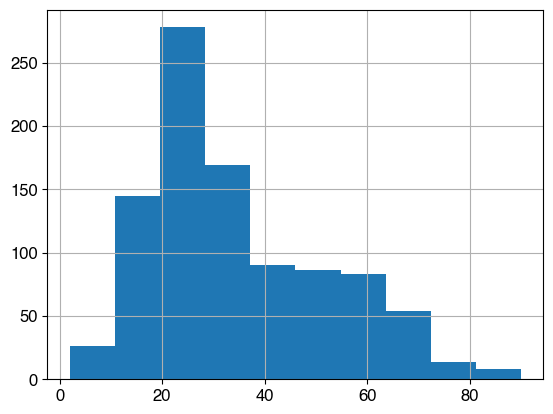

In [91]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["age"].hist()

In [92]:
specimens_to_keep_with_override_applied_and_dedupe_by_specimen["age"].describe()

count    953.000000
mean      34.576076
std       17.373635
min        2.000000
25%       22.000000
50%       30.000000
75%       47.000000
max       90.000000
Name: age, dtype: float64

In [93]:
# Apply age_group cut to the real object (not the dedupe specimens_to_keep_with_override_applied_and_dedupe_by_specimen)
specimens_to_keep["age_group"] = pd.cut(
    specimens_to_keep["age"],
    bins=[0, 20, 30, 40, 50, 60, 70, 80, 100],
    labels=["<20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"],
    right=False,
)
# Note this count is not with deduping:
specimens_to_keep["age_group"].value_counts()

20-30    296
<20      171
30-40    168
40-50    116
50-60     93
60-70     72
70-80     28
80+        9
Name: age_group, dtype: int64

In [94]:
specimens_to_keep["age_group"].cat.categories

Index(['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'], dtype='object')

In [95]:
# Note this count is not with deduping:
specimens_to_keep["age"].isna().value_counts()

False    953
True     258
Name: age, dtype: int64

In [96]:
# Note this count is not with deduping:
specimens_to_keep["age_group"].isna().value_counts()

False    953
True     258
Name: age_group, dtype: int64

In [97]:
# Note this count is not with deduping:
for age_group, grp in specimens_to_keep.groupby("age_group"):
    print(age_group, grp["age"].min(), grp["age"].max())

<20 2.0 19.0
20-30 20.0 29.0
30-40 30.0 39.0
40-50 40.0 49.0
50-60 50.0 59.0
60-70 60.0 69.0
70-80 70.0 79.0
80+ 81.0 90.0


In [98]:
# Note this count is not with deduping:
# Here's who is missing age:
specimens_to_keep[specimens_to_keep["age_group"].isna()]["disease"].value_counts()

Ulcerative colitis    84
Crohn's disease       84
T1D                   41
Healthy/Background    37
T2D                   10
Lupus                  2
Name: disease, dtype: int64

In [99]:
# Note this count is not with deduping:
# Here's who is missing age:
specimens_to_keep[specimens_to_keep["age_group"].isna()]["study_name"].value_counts()

IBD pre-pandemic Yoni        168
Diabetes biobank              51
IBD post-pandemic Gubatan     36
Lupus                          3
Name: study_name, dtype: int64

In [100]:
# Note this count is not with deduping:
# Versus total counts
specimens_to_keep["disease"].value_counts()

Healthy/Background    322
HIV                   197
Influenza             148
Lupus                 123
Covid19               114
T1D                   102
Ulcerative colitis     84
Crohn's disease        84
T2D                    37
Name: disease, dtype: int64

In [101]:
# Note this count is not with deduping:
# <20: only in HIV, Healthy, and Lupus
# 70-80: not in HIV
# 80+: only in Covid and Healthy

specimens_to_keep.groupby(["age_group", "disease"], observed=True).size()

age_group  disease           
<20        HIV                    4
           Healthy/Background    52
           Lupus                 43
           T1D                   45
           T2D                   27
20-30      Covid19               12
           HIV                   88
           Healthy/Background    77
           Influenza             96
           Lupus                 19
           T1D                    4
30-40      Covid19               22
           HIV                   57
           Healthy/Background    41
           Influenza             24
           Lupus                 19
           T1D                    5
40-50      Covid19               23
           HIV                   40
           Healthy/Background    33
           Influenza              4
           Lupus                 15
           T1D                    1
50-60      Covid19               17
           HIV                    6
           Healthy/Background    45
           Influenza              

In [102]:
# Null out "age_group" column for extreme ages with small sample size.

# Note that <20 is kept but is predominantly pediatric lupus.
# Keeping "70-80" despite small sample size, since there is a mix of disease types in there.
# 80+ is too small though.

# Note that we are not getting rid of these specimens altogether,
# but marking age_group NaN will disable their use for demographics-controlling models

orig_shapes = specimens_to_keep.shape[0], specimens_to_keep["age_group"].isna().sum()
mask = specimens_to_keep["age_group"].isin(["80+"])
specimens_to_keep.loc[mask, "age_group"] = np.nan
new_shapes = specimens_to_keep.shape[0], specimens_to_keep["age_group"].isna().sum()

# sanity checks:
# - we did not drop any specimens
assert orig_shapes[0] == new_shapes[0]
# - but we did null out some age_group entries
assert orig_shapes[1] < new_shapes[1]
# - we nulled out the right amount
assert new_shapes[1] - orig_shapes[1] == mask.sum()

In [103]:
# The raw specimen_label is not duplicated.
# However, note that once the specimen_label_override is applied, there may be duplicates.
assert not specimens_to_keep["specimen_label"].duplicated().any()

In [104]:
# All of these rows will get squashed into a single row per specimen
specimens_to_keep["specimen_label_override"].fillna(
    specimens_to_keep["specimen_label"]
).duplicated(keep=False).sum()

168

In [105]:
specimens_to_keep.drop(columns=["ethnicity"]).to_csv(
    config.paths.metadata_dir / "generated_combined_specimen_metadata.tsv",
    sep="\t",
    index=None,
)